# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

from pandas.api.types import CategoricalDtype


## 
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Utils

In [2]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    # takes most important coeffs in abs value
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

# Preprocessing

In [3]:
def categorize_and_transform(X):
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category')
    return OneHotEncoder().fit_transform(X).fillna(0)

In [ ]:
data = pd.read_csv("processed/BLCA_data_preprocessed.csv")#, low_memory=False)

In [26]:
modality_list = ["clinical",
"gex",
"rppa",
"mirna",
"mutation",
"meth",
"cnv"]

In [55]:
%%capture
Xt = []
for m in modality_list:
    modalities_to_keep = m
    modality_mask = [col for col in data.columns if col.rsplit("_")[0] in modalities_to_keep]
    Xt.append(categorize_and_transform(data[modality_mask]))

y = data[['OS', 'OS_days']].rename(columns={'OS_days' : 'time'}).rename(columns={'OS' : 'event'})
y['event'] = y['event'].astype(bool)
y = np.array(y.to_records(index=False))

# use PriorityLasso

In [52]:
from PriorityLassoCGPT import PriorityLASSO

In [53]:
alpha_value = 1.0
l1_ratio_value = 0.5
max_iter_value = 1000
priority_lasso_model = PriorityLASSO(alpha=alpha_value, l1_ratio=l1_ratio_value, max_iter=max_iter_value)
priority_lasso_model.fit(Xt, y)

TypeError: CoxnetSurvivalAnalysis.__init__() got an unexpected keyword argument 'alpha'

# Ridge - L2 Models to estabilish ranking

In [9]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

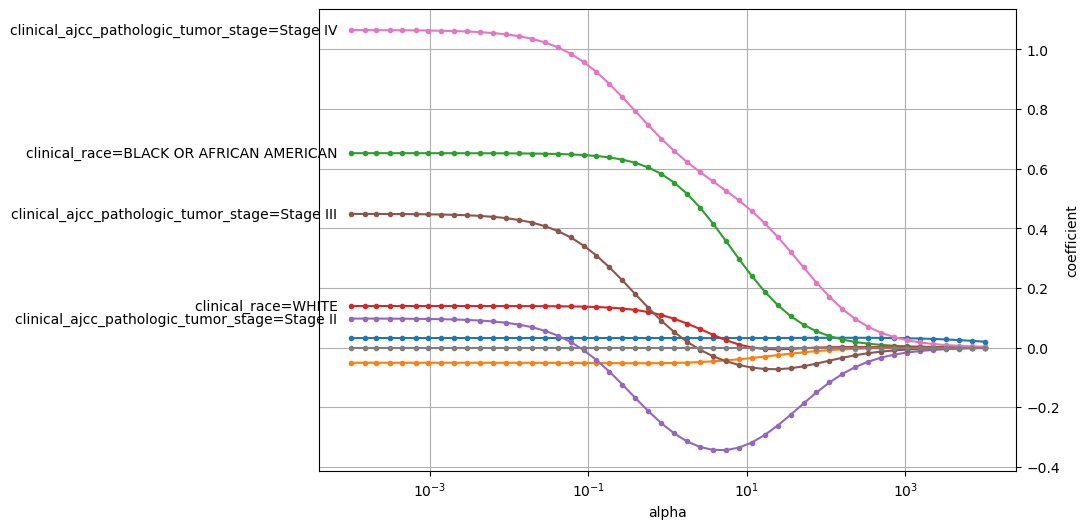

In [10]:
plot_coefficients(coefficients, n_highlight=5)

In [11]:
coefficients

alpha,0.00010,0.00015,0.00021,0.00031,0.00045,0.00066,0.00095,0.00139,0.00202,0.00295,...,339.32218,494.17134,719.68567,1048.11313,1526.41797,2222.99648,3237.45754,4714.86636,6866.48845,10000.00000
clinical_age_at_initial_pathologic_diagnosis,0.031822,0.031822,0.031822,0.031822,0.031822,0.031822,0.031822,0.031822,0.031822,0.031822,...,0.032498,0.032224,0.031774,0.031098,0.030139,0.028830,0.027113,0.024957,0.022382,0.019477
clinical_gender=MALE,-0.051096,-0.051097,-0.051098,-0.051099,-0.051101,-0.051103,-0.051107,-0.051113,-0.051121,-0.051133,...,-0.003161,-0.002203,-0.001530,-0.001060,-0.000735,-0.000509,-0.000354,-0.000247,-0.000172,-0.000121
clinical_race=BLACK OR AFRICAN AMERICAN,0.652100,0.652097,0.652093,0.652087,0.652078,0.652065,0.652046,0.652019,0.651979,0.651920,...,0.012736,0.008762,0.006014,0.004119,0.002816,0.001920,0.001306,0.000886,0.000600,0.000405
clinical_race=WHITE,0.139221,0.139220,0.139219,0.139218,0.139215,0.139212,0.139208,0.139201,0.139191,0.139176,...,0.001413,0.001167,0.000921,0.000709,0.000540,0.000412,0.000315,0.000244,0.000189,0.000147
clinical_ajcc_pathologic_tumor_stage=Stage II,0.097148,0.097074,0.096967,0.096812,0.096585,0.096255,0.095776,0.095080,0.094071,0.092610,...,-0.047395,-0.033829,-0.023899,-0.016764,-0.011706,-0.008152,-0.005670,-0.003943,-0.002742,-0.001908
clinical_ajcc_pathologic_tumor_stage=Stage III,0.448284,0.448210,0.448103,0.447947,0.447720,0.447389,0.446909,0.446212,0.445200,0.443736,...,-0.019003,-0.013652,-0.009659,-0.006758,-0.004688,-0.003229,-0.002212,-0.001508,-0.001024,-0.000693
clinical_ajcc_pathologic_tumor_stage=Stage IV,1.065002,1.064928,1.064820,1.064663,1.064435,1.064103,1.063621,1.062921,1.061906,1.060435,...,0.069325,0.049495,0.034943,0.024475,0.017048,0.011832,0.008192,0.005663,0.003912,0.002701
clinical_clinical_stage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Lasso - Study coefficients behaviour changing alpha

In [12]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, verbose=True)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0, verbose=True)

In [13]:
cox_lasso.get_params()

{'alpha_min_ratio': 0.01,
 'alphas': None,
 'copy_X': True,
 'fit_baseline_model': False,
 'l1_ratio': 1.0,
 'max_iter': 100000,
 'n_alphas': 100,
 'normalize': False,
 'penalty_factor': None,
 'tol': 1e-07,
 'verbose': True}

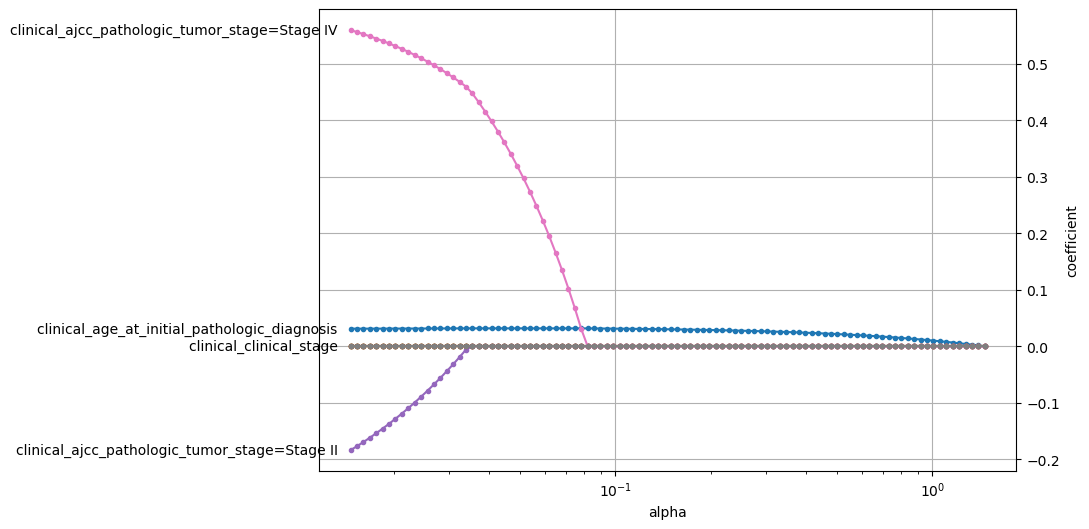

In [14]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=4)

# Elastic-Net - a caso

In [15]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

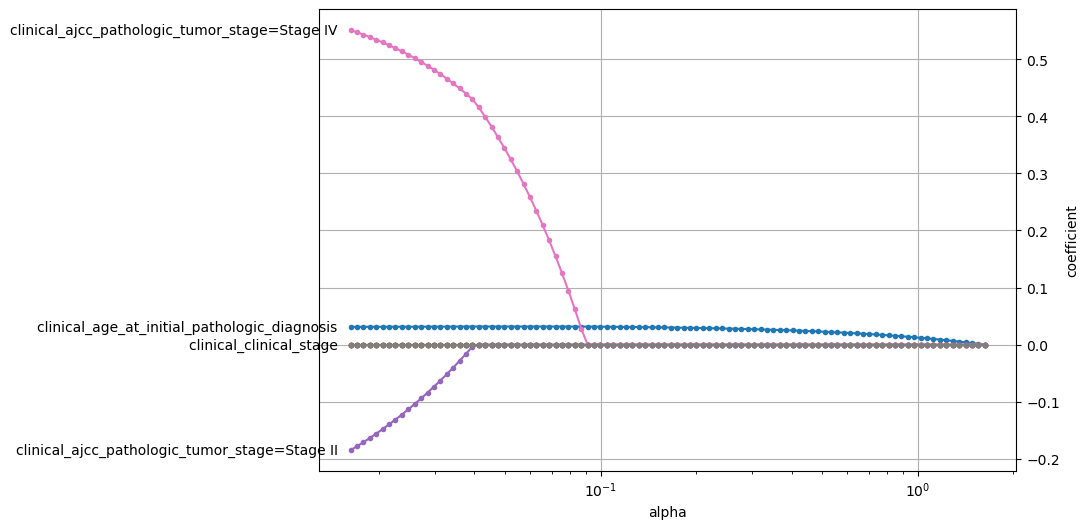

In [16]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=4)

# Omic score

In [17]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [18]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.001)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

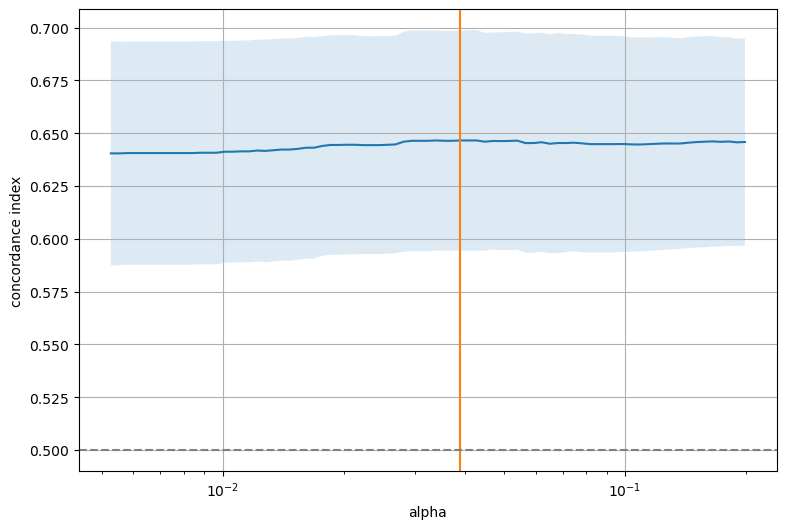

In [19]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 7


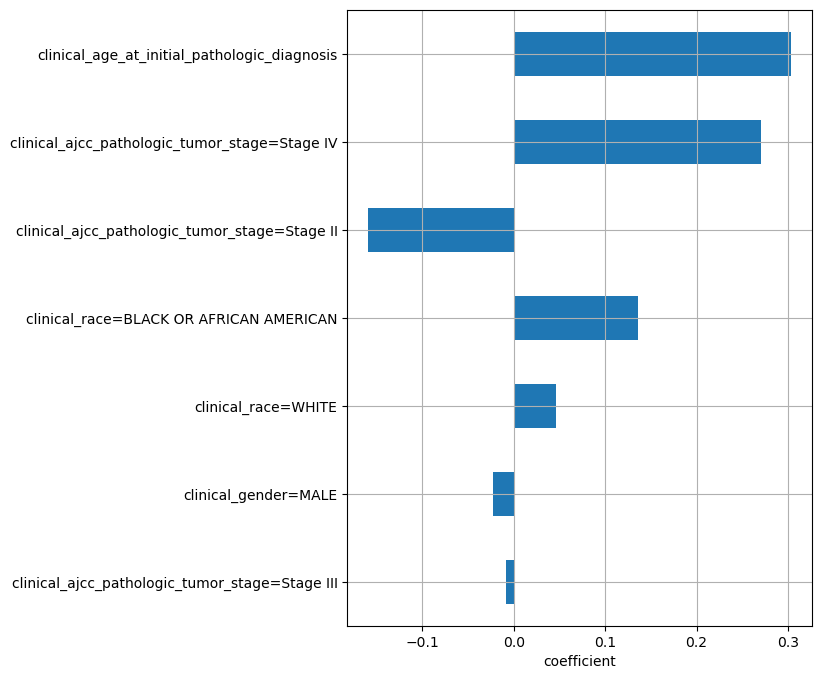

In [20]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [21]:
# score -> surrogate for knowledge-based priority order
np.absolute(best_coefs["coefficient"].to_numpy()).mean()

0.11825913457491835

# Best Alphas

Before we can use GridSearchCV, we need to determine the set of alphas which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. 
Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. 
Note that we are using StandardScaler to account for scale differences among features and allow direct comparison of coefficients.

In [22]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [23]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

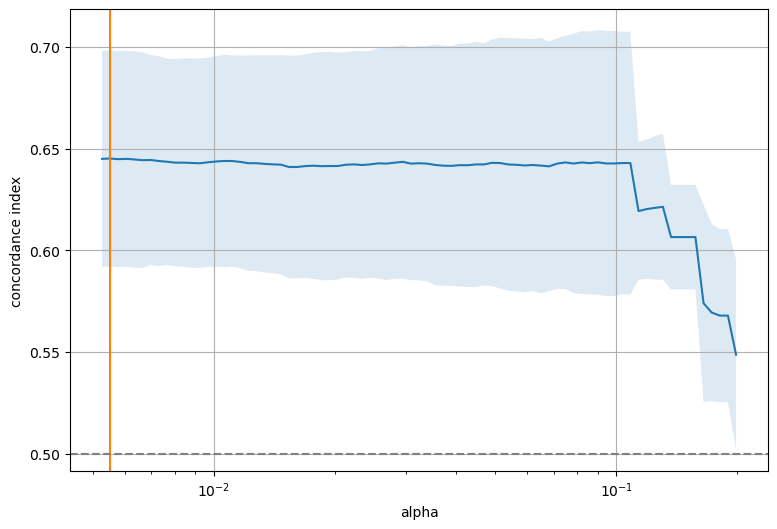

In [24]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 6


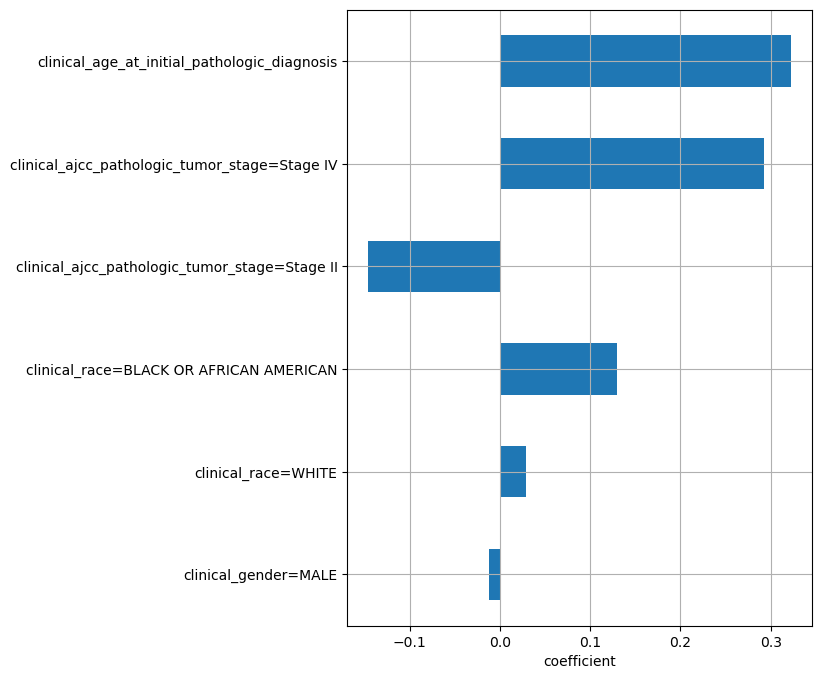

In [25]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [26]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.005525453596631809],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [27]:
Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int)

0      1
1      1
2      0
3      0
4      0
      ..
325    0
326    0
327    0
328    0
329    1
Name: clinical_ajcc_pathologic_tumor_stage=Stage IV, Length: 330, dtype: int64

label =  0
len =  0
label =  1
len =  1


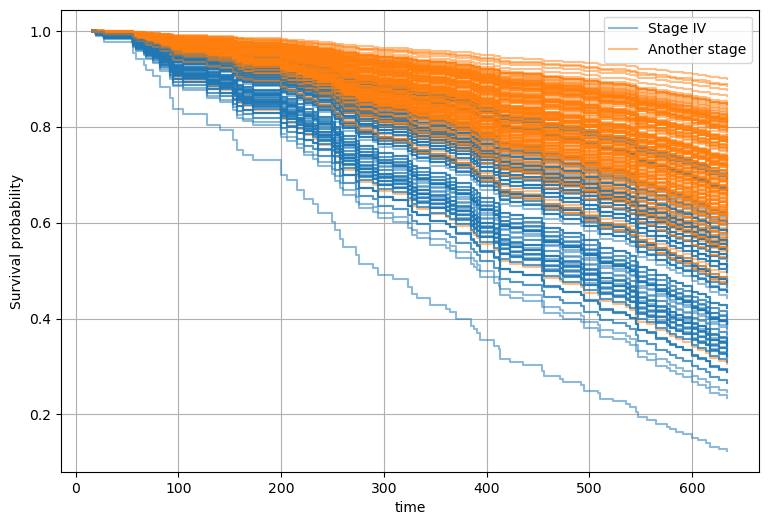

In [29]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, (-Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int).astype(bool)).astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label: 
        print("label = ", label)
        print("len = ", len(legend_handles))
        name =  "Another stage" if label == 1 else "Stage IV"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [30]:
(-Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int).astype(bool)).astype(int)

0      0
1      0
2      1
3      1
4      1
      ..
325    1
326    1
327    1
328    1
329    0
Name: clinical_ajcc_pathologic_tumor_stage=Stage IV, Length: 330, dtype: int64

label =  0
len =  0
label =  1
len =  1


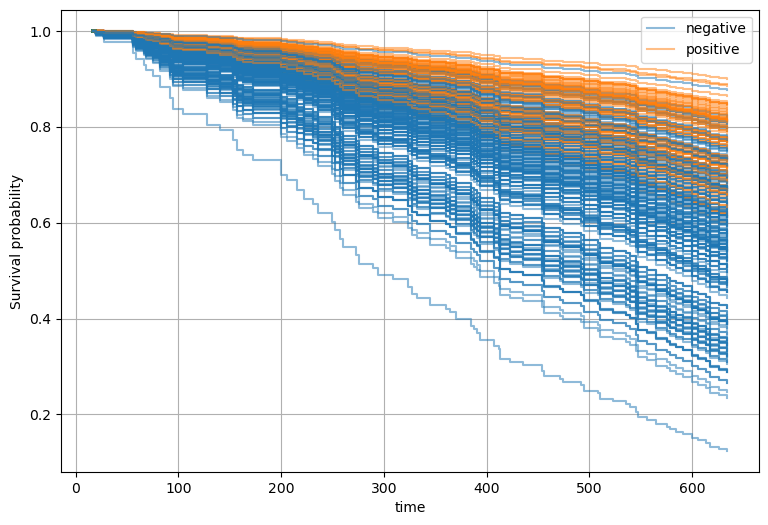

In [31]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage II"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label:
        print("label = ", label)
        print("len = ", len(legend_handles))
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [54]:

min_value = Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].min()
max_value = Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].max()

surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
fig, ax = plt.subplots(figsize=(9, 6))
cmap = matplotlib.colormaps['viridis']
for fn, label in zip(surv_fns, Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].astype(int)):
    normalized_color = (label - min_value) / (max_value - min_value)
    (line,) = ax.step(time_points, fn(time_points), where="post", color = cmap(normalized_color), alpha=0.5)
    if len(legend_handles) <= label and ((label >= max_value - 2 ) or (label <= min_value + 5)):
        name = label
        legend_labels.append(name)
        legend_handles.append(line)

norm = plt.Normalize(vmin=min_value, vmax=max_value)  # Normalize the data range to [0, 1]
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

#ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

AttributeError: 'list' object has no attribute 'loc'

# Crossval

In [129]:
# Initialize the 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
coefficients_df = pd.DataFrame()
alphas = []

## alpha -> best alpha on average -> refit best alpha each fold and take coefficients
## mean mean absolute error  of non-censored !!!!!!!

for i, (train_index, test_index) in enumerate(kf.split(Xt)):
    X_train = Xt.iloc[train_index]
    X_test = Xt.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", FitFailedWarning)
    coxnet_pipe.fit(X_train, y_train)
    estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
    ).fit(X_train, y_train)

    #cv_results = pd.DataFrame(gcv.cv_results_)
    best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
    best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])
    
    alphas.append(best_model)
    
    if coefficients_df.empty:
        coefficients_df = best_coefs
        coefficients_df.rename(columns={'coefficient': 'coeff_0'}, inplace=True)
    else:
        coefficients_df[f"coeff_{i}"] = best_coefs

# Convert the list of coefficients into a DataFrame for easy visualization
#coefficients_df = pd.DataFrame(coefficients_list)
#print(coefficients_df)

In [130]:
alphas

[CoxnetSurvivalAnalysis(alphas=[0.041141045747191636], l1_ratio=0.9),
 CoxnetSurvivalAnalysis(alphas=[0.03388185431989301], l1_ratio=0.9),
 CoxnetSurvivalAnalysis(alphas=[0.007038612269828779], l1_ratio=0.9),
 CoxnetSurvivalAnalysis(alphas=[0.004651772827244609], l1_ratio=0.9),
 CoxnetSurvivalAnalysis(alphas=[0.059163284662795586], l1_ratio=0.9)]

In [74]:
coefficients_df

,coeff_0,coeff_1,coeff_2,coeff_3,coeff_4
clinical_age_at_initial_pathologic_diagnosis,0.326246,0.172202,0.264646,0.377796,0.203760
clinical_gender=MALE,-0.002361,0.000000,0.000000,0.051169,0.000000
clinical_race=BLACK OR AFRICAN AMERICAN,0.076431,0.094310,0.150527,0.147822,0.000000
clinical_race=WHITE,0.000000,0.000000,0.055207,0.046936,0.000000
clinical_ajcc_pathologic_tumor_stage=Stage II,-0.115129,-0.080409,-0.168873,0.000000,-0.061347
clinical_ajcc_pathologic_tumor_stage=Stage III,0.000000,0.000000,0.000000,0.096564,0.000000
clinical_ajcc_pathologic_tumor_stage=Stage IV,0.259999,0.208705,0.245839,0.417860,0.313186
clinical_clinical_stage,0.000000,0.000000,0.000000,0.000000,0.000000


In [75]:
coefficents_cv = pd.DataFrame(coefficients_df.mean(axis=1))
coefficents_cv.rename(columns={ 0 : 'coeff_CV'}, inplace=True)
coefficents_cv

,coeff_CV
clinical_age_at_initial_pathologic_diagnosis,0.268930
clinical_gender=MALE,0.009762
clinical_race=BLACK OR AFRICAN AMERICAN,0.093818
clinical_race=WHITE,0.020429
clinical_ajcc_pathologic_tumor_stage=Stage II,-0.085152
clinical_ajcc_pathologic_tumor_stage=Stage III,0.019313
clinical_ajcc_pathologic_tumor_stage=Stage IV,0.289118
clinical_clinical_stage,0.000000


# get residual

In [89]:
coefficents_cv['coeff_CV'].to_dict()

{'clinical_age_at_initial_pathologic_diagnosis': 0.26893032980991455,
 'clinical_gender=MALE': 0.009761737947847439,
 'clinical_race=BLACK OR AFRICAN AMERICAN': 0.09381811256464363,
 'clinical_race=WHITE': 0.020428602586989243,
 'clinical_ajcc_pathologic_tumor_stage=Stage II': -0.08515167933527454,
 'clinical_ajcc_pathologic_tumor_stage=Stage III': 0.019312794061825855,
 'clinical_ajcc_pathologic_tumor_stage=Stage IV': 0.2891178793907106,
 'clinical_clinical_stage': 0.0}

In [101]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

In [102]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

In [103]:
best_model.coef_

array([[ 0.32145068],
       [-0.01047596],
       [ 0.12678079],
       [ 0.02583571],
       [-0.14439684],
       [ 0.        ],
       [ 0.29292695],
       [ 0.        ]])

In [104]:
best_model.coef_ = coefficents_cv.to_numpy()
best_model.coef_

array([[ 0.26893033],
       [ 0.00976174],
       [ 0.09381811],
       [ 0.0204286 ],
       [-0.08515168],
       [ 0.01931279],
       [ 0.28911788],
       [ 0.        ]])

In [123]:
best_model.predict(Xt)[:10]

array([17.79977966, 16.7142966 , 21.28523745, 19.14355655, 16.08085845,
       18.87462622, 18.49146968, 15.1096016 , 17.7989049 , 17.79977966])

In [119]:
y2 = y

In [120]:
y2['time'] =  y['time'] - best_model.predict(Xt)

In [124]:
y[:10]

array([(False,  336), (False, 1615), ( True,  215), ( True,  550),
       (False, 1727), ( True, 1039), (False, 1676), (False, 1798),
       (False, 1770), ( True,  563)],
      dtype=(numpy.record, [('event', '?'), ('time', '<i8')]))

In [125]:
y2[:10]

array([(False,  336), (False, 1615), ( True,  215), ( True,  550),
       (False, 1727), ( True, 1039), (False, 1676), (False, 1798),
       (False, 1770), ( True,  563)],
      dtype=(numpy.record, [('event', '?'), ('time', '<i8')]))